In [ ]:
# add the following code snippet to the JavaScript console of the Colab browser window to stop Google 
# Colab from disconnecting
# function ClickConnect() {
#   console.log('Working')
#   document
#     .querySelector('#top-toolbar > colab-connect-button')
#     .shadowRoot.querySelector('#connect')
#     .click()
# }
# setInterval(ClickConnect, 60000)

In [1]:
%%capture
!git clone https://github.com/chloeh13q/ISIC-skin-lesion

In [2]:
%%capture
%%bash
cd ISIC-skin-lesion/
mkdir data; cd data
# get training data
wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip && unzip train.zip; rm train.zip
# get validation data
wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip && unzip valid.zip; rm valid.zip
# get test data
wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip && unzip test.zip; rm test.zip

In [5]:
import os
os.chdir('ISIC-skin-lesion/')
os.getcwd()

'/content/ISIC-skin-lesion'

In [6]:
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
import re

%matplotlib inline

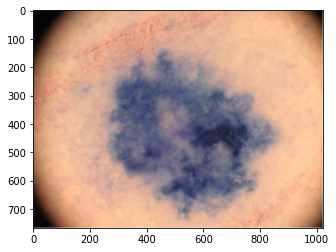

In [7]:
# load and display a sample image
img_path = 'data/train/melanoma/ISIC_0000002.jpg'
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

In [8]:
import torchvision
from torchvision import datasets
from torchvision import transforms

In [9]:
def get_dataloader(batch_size, num_workers, image_size, data_dir):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """

    transform = transforms.Compose([transforms.Resize((image_size, image_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
      
    image_folder = datasets.ImageFolder(data_dir, transform=transform)
    data_loader = torch.utils.data.DataLoader(image_folder, num_workers=num_workers, 
                                              batch_size=batch_size, shuffle=True)

    return data_loader

In [10]:
train_dir = './data/train/'
valid_dir = './data/valid/'
test_dir = './data/test/'

batch_size = 64
num_workers = 1
image_size = 256

data_loader = {'train': get_dataloader(batch_size, num_workers, image_size, train_dir),
               'valid': get_dataloader(batch_size, num_workers, image_size, valid_dir),
               'test': get_dataloader(batch_size, num_workers, image_size, test_dir)}

In [11]:
# define dictionary to map np label back to class label
classes = [d.name for d in os.scandir(train_dir) if d.is_dir()]
classes.sort()
class_to_idx = {i: cls_name for i, cls_name in enumerate(classes)}

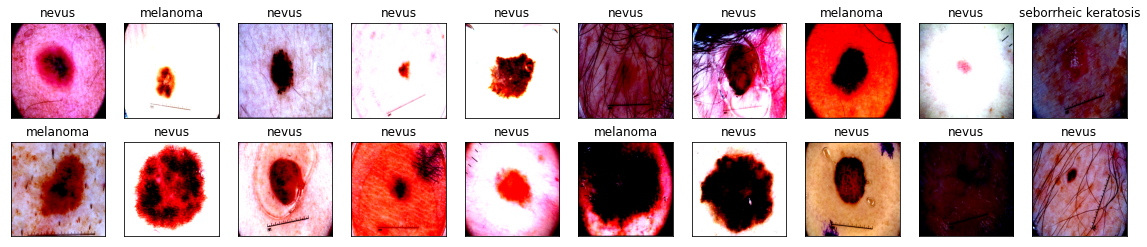

In [12]:
# display 20 images from the training set dataloader
def imshow(img):
  npimg = img.numpy()
  npimg = np.transpose(npimg, (1, 2, 0))
  npimg = np.clip(npimg, 0, 1)
  plt.imshow(npimg)

dataiter = iter(data_loader['train'])
images, labels = dataiter.next()

fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    label = re.sub('_', ' ', class_to_idx[labels.numpy()[idx]])
    ax.set_title(label)
    imshow(images[idx])

In [13]:
import torch.nn as nn
import torch.nn.functional as F

train_on_cuda = torch.cuda.is_available()

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    # define convolutional layers
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

    # define maxpooling layer
    self.pool = nn.MaxPool2d(2, 2)

    # define fully-connected layers
    self.fc1 = nn.Linear(128*16*16, 4096)
    self.fc2 = nn.Linear(4096, 256)
    self.fc3 = nn.Linear(256, 3)

    # define dropout layer
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = x.view(-1, 128*16*16)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = Model()
if train_on_cuda:
  print('Train on GPU')
  model = model.cuda()
else:
  print('Train on CPU')

Train on GPU


In [14]:
print(model)

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [15]:
import torch.optim as optim

learning_rate = 0.01
gamma = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

In [19]:
def train(n_epochs, loaders, model, optimizer, criterion, train_on_cuda, save_path):
  """returns trained model"""
  min_valid_loss = np.Inf

  for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0

    # set model to training mode
    model.train()
    for batch_idx, (data, target) in enumerate(data_loader['train']):

      # move data to GPU if available
      if train_on_cuda:
        data, target = data.cuda(), target.cuda()
      
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))

    # set model to evaluation mode
    model.eval()
    for batch_idx, (data, target) in enumerate(data_loader['valid']):

      # move data to GPU if available
      if train_on_cuda:
        data, target = data.cuda(), target.cuda()

      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
        valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

    print('Epoch: ', epoch, '; LR: ', scheduler.get_last_lr())
    print('Training loss: {:.6f} \tValidation loss: {:.6f}'.format(train_loss, valid_loss))

    # update optimizer learning rate
    scheduler.step()

    # if new valid_loss < current min_valid_loss, update min_valid_loss and save model
    if valid_loss < min_valid_loss:
      min_valid_loss = valid_loss
      torch.save(model.state_dict(), save_path)
      print('Model saved...')

  return model

In [ ]:
n_epochs = 25
model = train(n_epochs, data_loader, model, optimizer, criterion, train_on_cuda, 'model.pt')

In [21]:
def test(data_loader, model, optimizer, criterion, train_on_cuda):

  test_loss = 0.0
  correct = 0
  total = 0

  model.eval()

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(data_loader['test']):
      # move data to GPU if available
      if train_on_cuda:
        data, target = data.cuda(), target.cuda()

      output = model(data)
      loss = criterion(output, target)
      test_loss += ((1 / (batch_idx + 1)) * (loss.data - test_loss))

      pred = output.data.max(1, keepdim=True)[1]
      correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
      total += data.size(0)

    print('Test loss: {:.6f}\n'.format(test_loss))
    print('Test accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [23]:
# reload saved model
model.load_state_dict(torch.load('model.pt'))

test(data_loader, model, optimizer, criterion, train_on_cuda)

Test loss: 0.835483

Test accuracy: 65% (392/600)


In [ ]:
dataiter = iter(data_loader['test'])
images, labels = dataiter.next()

fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    label = re.sub('_', ' ', class_to_idx[labels.numpy()[idx]]) + 
    ax.set_title(label)
    imshow(images[idx])